# Detecção de Fraude

Baseado no curso _Outspoken Market na Prática_ (Leandro Guerra)

Dataset:
- https://www.kaggle.com/mlg-ulb/creditcardfraud
- Dados anonimizados
- Transações de cartão de crédito, onde 0.172% são casos de fraude.


Notas:
- A fraude pode estar sendo cometida pelo cliente ou ele sofrendo uma fraude.
- Estima-se que sejam perdidos anualmente US$ 5 tri no mundo (valor do nível de PIB de país do G7).
- Definição:
    - Mal pagador:
        - Começa pagando regularmente as parcelas e em algum momento se torna inadimplente.
    - Fraude: 
        - Ja entra no negocio com o objetivo de fraudar o sistema.

Etapas do projeto:
 - Entendimento do problema de detecção de fraude
 - Tratamento da base
 - Análise exploratória dos dados
 - Preparação da base para treinamento e teste
 - Treinamento do modelo - Utilização do algoritmo **Isolation Forest**
 - Avaliação dos resultados

****

### Carregar as bibliotecas

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
from babel.numbers import format_currency # conversão de float para moeda local

# Para remover os warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

****
### Input da base de dados

In [2]:
df = pd.read_csv("creditcard.csv", sep = ",")

df.shape[0]

284807

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


A coluna 'Class' é o alvo, onde 0 é para transações normais e 1 para transações fraudulentas.

As variáveis V1 à V8 são as componentes principais das variáveis originais (anonimizadas por regra de compliance).

****
### Tratamento, entendimento da base e a descrição dos dados

In [4]:
# Estatísticas da base
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# Verifica se existem missing values
df.isnull().values.any()

False

In [6]:
# Verifica a distribuição entre as classes
print(f"Percentual de fraudes: {round(df[df['Class'] == 1].shape[0]/df.shape[0]*100, 3)} %")

Percentual de fraudes: 0.173 %


In [7]:
df["Class"].describe()

count    284807.000000
mean          0.001727
std           0.041527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

Fazer o describe para toda a base não ajuda muito no entendimento/visualização da base, pois a parte onde há fraudes é muito pequena.

Por isso, convêm separar a base pelas classes e fazer o describe separadamente.

In [8]:
# Estatísticas para casos de não fraudes (0)
df[df["Class"] == 0]["Amount"].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [9]:
# Estatísticas para casos de fraudes (1)
df[df["Class"] == 1]["Amount"].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Nota-se que os valores máximos de onde há fraude são muito menores do que quando não ha fraude. Porém a média do montante das fraudes é maior.

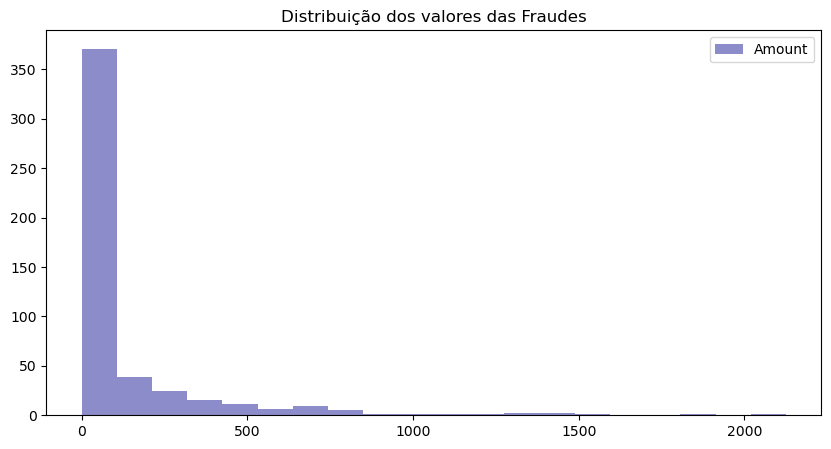

In [10]:
plt.figure(figsize = (10,5))
plt.hist(df[df["Class"] == 1]["Amount"], 
         bins = 20, 
         alpha = 0.45, 
         histtype = "stepfilled", 
         color = "darkblue", 
         edgecolor = "none", 
         label = "Amount")
plt.legend()
plt.title("Distribuição dos valores das Fraudes")
plt.show()

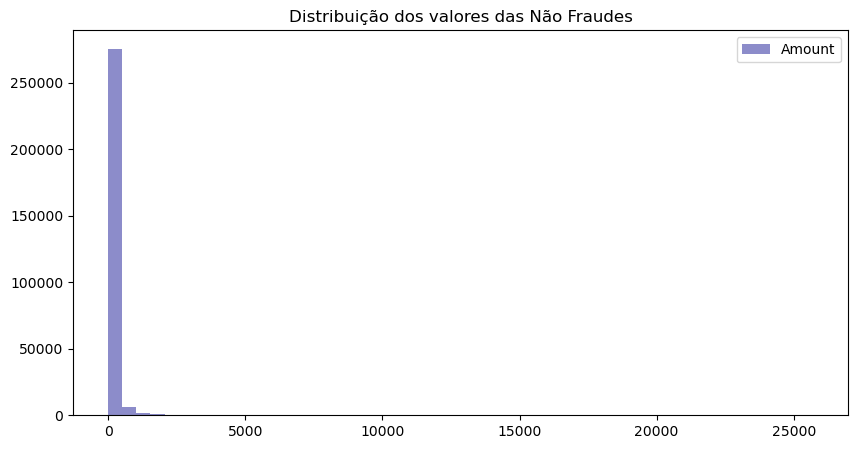

In [11]:
plt.figure(figsize = (10,5))
plt.hist(df[df["Class"] == 0]["Amount"], 
         bins = 50, 
         alpha = 0.45, 
         histtype = "stepfilled", 
         color = "darkblue", 
         edgecolor = "none", 
         label = "Amount")
plt.legend()
plt.title("Distribuição dos valores das Não Fraudes")
plt.show()

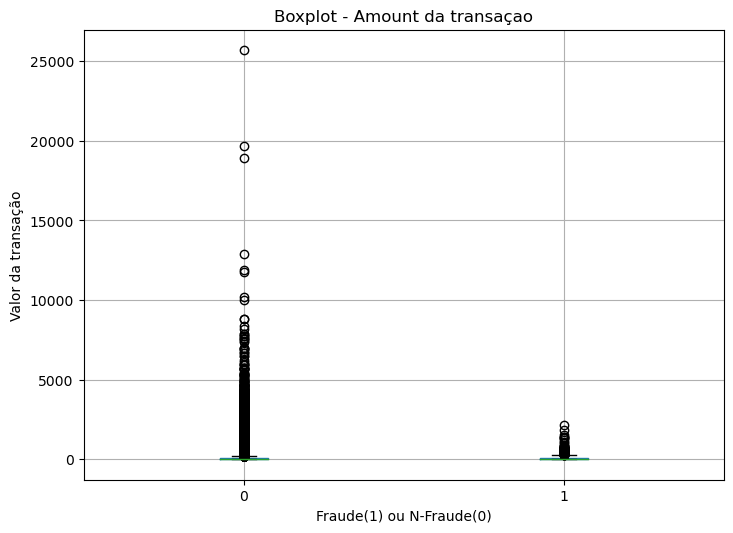

In [12]:
df.boxplot(by ="Class", column =["Amount"], grid = True, figsize = (8,6)); 
plt.title("Boxplot - ""Amount"" da transaçao")
plt.suptitle("") #para eliminar o titulo padrao do boxplot do pandas
plt.ylabel("Valor da transação")
plt.xlabel("Fraude(1) ou N-Fraude(0)")
plt.show()

In [13]:
# Convertendo variável "Amount" para log

import numpy as np
df["Amount_log"] = np.log(df["Amount"])
df["Amount_log"] = np.where(df["Amount_log"] == -np.inf, 0, df["Amount_log"])

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008099
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989541
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.936639
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.816241
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.248352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,-0.261365
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,3.210440
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,4.217741
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,2.302585


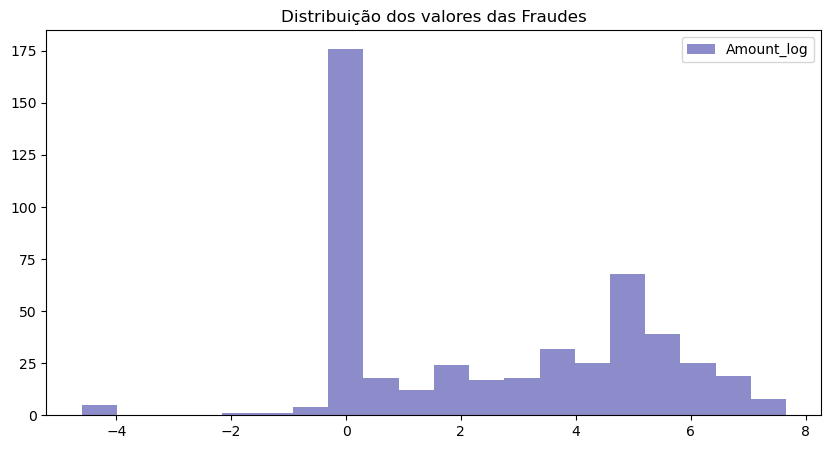

In [14]:
plt.figure(figsize = (10,5))
plt.hist(df[df["Class"] == 1]["Amount_log"], 
         bins = 20, 
         alpha = 0.45, 
         histtype = "stepfilled", 
         color = "darkblue", 
         edgecolor = "none", 
         label = "Amount_log")
plt.legend()
plt.title("Distribuição dos valores das Fraudes")
plt.show()

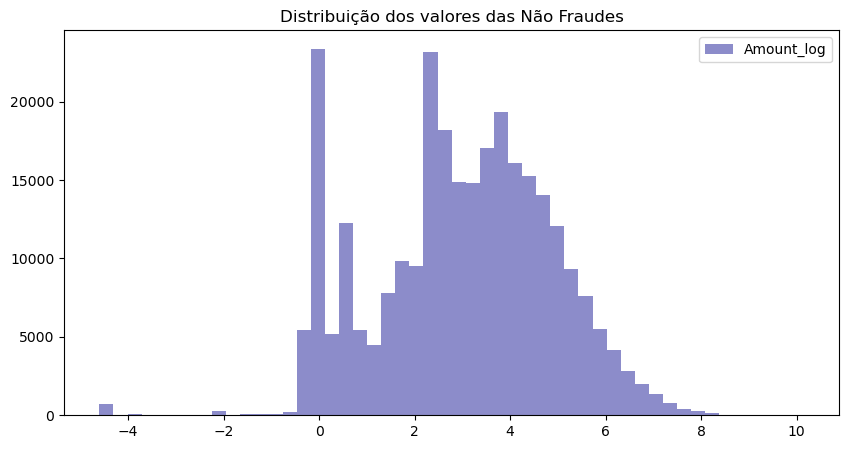

In [15]:
plt.figure(figsize = (10,5))
plt.hist(df[df["Class"] == 0]["Amount_log"], 
         bins = 50, 
         alpha = 0.45, 
         histtype = "stepfilled", 
         color = "darkblue", 
         edgecolor = "none", 
         label = "Amount_log")
plt.legend()
plt.title("Distribuição dos valores das Não Fraudes")
plt.show()

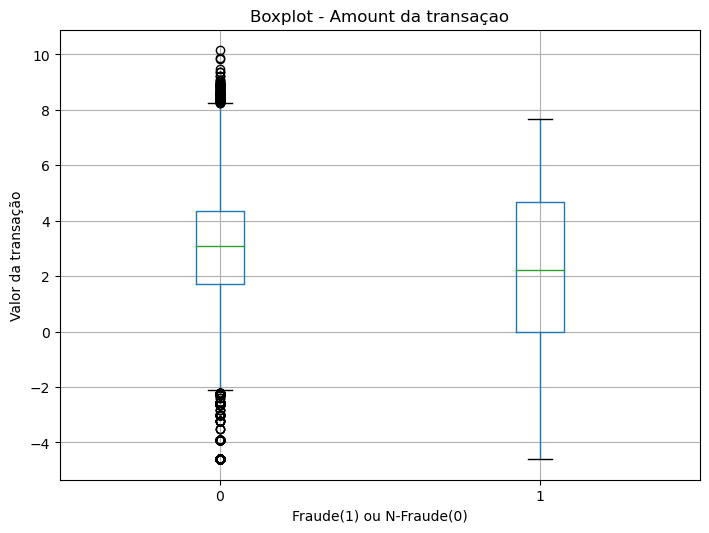

In [16]:
df.boxplot(by ="Class", column =["Amount_log"], grid = True, figsize = (8,6)); 
plt.title("Boxplot - ""Amount"" da transaçao")
plt.suptitle("") #para eliminar o titulo padrao do boxplot do pandas
plt.ylabel("Valor da transação")
plt.xlabel("Fraude(1) ou N-Fraude(0)")
plt.show()

****
### Preparação da base para treinamento e teste

In [17]:
# Separando os dados com as variaveis em x e o alvo em y
x = df.drop(columns=["Class", "Time"])
y = df["Class"]

# Separando entre treinamento e teste - mantendo "Amount" em X para avaliação financeira
x_train_aval, x_test_aval, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 42)

# Dropando "Amount" para treinar o modelo
x_train = x_train_aval.drop(columns=["Amount"])
x_test = x_test_aval.drop(columns=["Amount"])

In [18]:
len(x)

284807

****
### Treinamento do modelo

#### Isolation Forest

O Isolation Forest é um algoritmo de detecção de anomalias que se baseia no conceito de isolamento. Ele é uma abordagem eficiente para detectar anomalias em conjuntos de dados.

A ideia principal é que as anomalias são mais facilmente isoladas do que as instâncias normais em um conjunto de dados. O algoritmo constrói uma série de árvores de decisão aleatórias, onde cada árvore é treinada para isolar um conjunto de dados em relação às instâncias normais.

Uma vez que as árvores são construídas, o processo de isolamento é medido em termos do caminho percorrido por uma instância para alcançar uma folha. Instâncias anômalas tendem a ter caminhos mais curtos devido à sua natureza incomum, enquanto instâncias normais tendem a ter caminhos mais longos.

A pontuação de anomalia para uma instância é determinada pela média do comprimento do caminho percorrido em todas as árvores. Quanto mais curto for o caminho médio, maior será a pontuação de anomalia atribuída à instância.

O Isolation Forest pode ser aplicado em várias aplicações, como detecção de fraudes, detecção de intrusões, detecção de outliers e identificação de comportamentos anormais em dados.

In [19]:
# Treinando o modelo
if_model = IsolationForest(n_estimators = 200, 
                             max_samples = len(x), 
                             random_state = 42)
if_model.fit(x_train) 

IsolationForest(max_samples=284807, n_estimators=200, random_state=42)

In [20]:
# Predições para o treinamento e teste
y_pred_train = if_model.predict(x_train)
y_pred_test = if_model.predict(x_test)

In [21]:
y_pred_test

array([-1,  1,  1, ...,  1,  1,  1])

In [22]:
# Da documentação do Isolation Forest:
#    Returna -1 para outliers e 1 para inliers.

# Reajustando a previsão para ficar alinhado com a Class da base
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test  = np.where(y_pred_test == -1, 1, 0)

In [23]:
print(np.count_nonzero(y_pred_train == 1))
print(np.count_nonzero(y_train == 1))

334
246


In [24]:
print(np.count_nonzero(y_pred_test == 1))
print(np.count_nonzero(y_test == 1))

319
246


****
### Avaliação dos Resultados

In [25]:
print("Percentual de fraudes")
print(f"Base de treinamento: {round(accuracy_score(y_train,y_pred_train) * 100, 2)}")
print(f"Base de teste:       {round(accuracy_score(y_test,y_pred_test) * 100, 2)}")

Percentual de fraudes
Base de treinamento: 99.72
Base de teste:       99.75


##### Lembrando que:
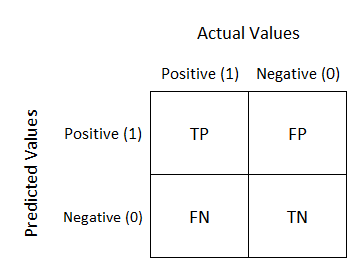

Obs.: Analisar a Matriz de Confusão para dados desbalanceados pode não ser uma boa opção. Por isso cabe ainda analisar os Falso Positivos.

In [26]:
# Treinamento
print(confusion_matrix(y_train, y_pred_train))
print("--------------------------------------------------------------------------------")
print(classification_report(y_train, y_pred_train))

[[141911    246]
 [   158     88]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142157
           1       0.26      0.36      0.30       246

    accuracy                           1.00    142403
   macro avg       0.63      0.68      0.65    142403
weighted avg       1.00      1.00      1.00    142403



In [27]:
# Teste
print(confusion_matrix(y_test, y_pred_test))
print("--------------------------------------------------------------------------------")
print(classification_report(y_test, y_pred_test))

[[141945    213]
 [   140    106]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142158
           1       0.33      0.43      0.38       246

    accuracy                           1.00    142404
   macro avg       0.67      0.71      0.69    142404
weighted avg       1.00      1.00      1.00    142404



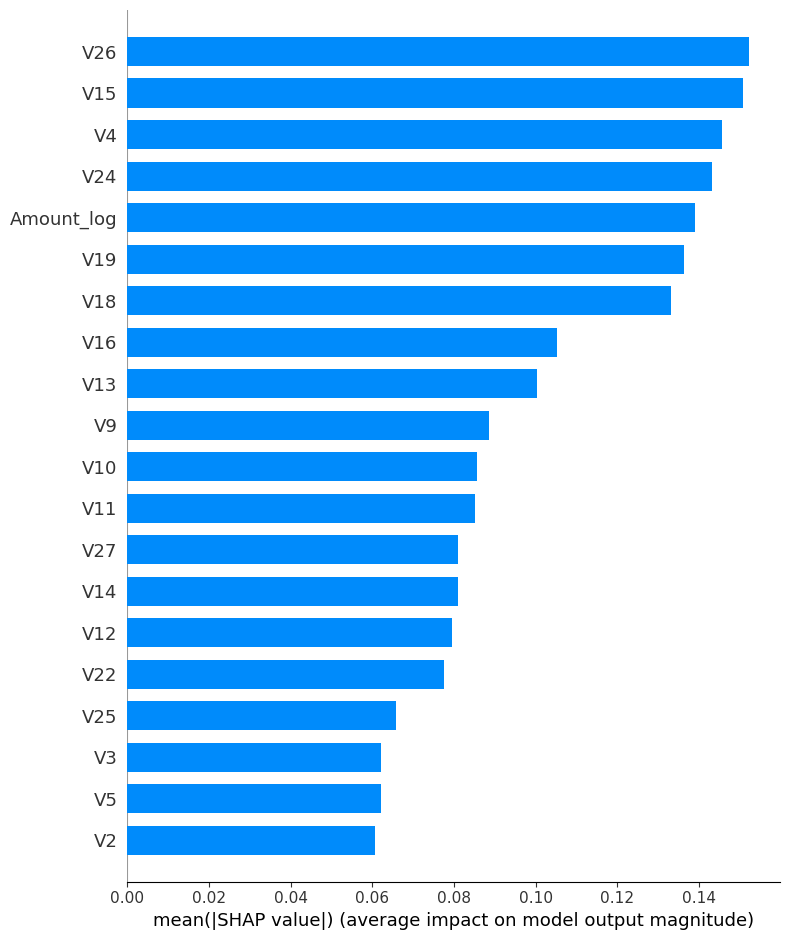

In [33]:
import shap

# Análise das features do modelo
explainer = shap.TreeExplainer(if_model)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(x_test[:1000])

shap.summary_plot(shap_values, x_test[:1000], plot_type="bar")
